<a href="https://colab.research.google.com/github/budennovsk/Pandas/blob/master/ES_server_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def errors_metrics(y_true, y_pred,name):
    from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,r2_score

    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name}_Mean Absolute Error_средняя абсолютная ошибка: {mae}")

    mse = mean_squared_error(y_true, y_pred)
    print(f"{name}_Mean Squared Error_Среднеквадратичная ошибка: {mse}")

    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{name}_Mean Absolute Percentage Error_Средняя абсолютная процентная ошибка: {mape}")

    r2 = r2_score(y_true, y_pred)
    print(f"{name}_R^2 Score_Коэффициент детерминации: {r2}")


In [3]:
def ensemble_catboost(model_add,model_mul,time_series):
    from catboost import CatBoostRegressor
    import matplotlib.pyplot as plt

    X_train = pd.DataFrame({
        'model1_prediction': model_add.fittedvalues,
        'model2_prediction': model_mul.fittedvalues
    })

    y_train = time_series.loc[:end_train].values

    # Создание и обучение модели CatBoost
    ensemble_model = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6)
    ensemble_model.fit(X_train, y_train,verbose=False)

    # Предсказание с помощью ансамбля
    X_test = pd.DataFrame({
        'model1_prediction': model_add.forecast(steps=52),
        'model2_prediction': model_mul.forecast(steps=52)
    })

    ensemble_predictions = ensemble_model.predict(X_test)


    # Построение графика прогнозов ансамбля
    plt.figure(figsize=(12, 6))
    plt.plot(time_series.index, time_series.values, label='True values', color='blue')
    plt.plot(time_series.loc[end_train:].index, ensemble_predictions, label='Ensemble Predictions', color='red')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title('Ensemble Predictions Catboost vs True Values')
    plt.legend()
    plt.show()
    return ensemble_predictions


In [4]:
def ensemble_mean(model_add,model_mul,time_series):
    X_test = pd.DataFrame({
        'model1_prediction': model_add.forecast(steps=26),
        'model2_prediction': model_mul.forecast(steps=26)
    })
    # Создание новой колонки col_mean со средним значением между col1 и col2
    X_test['predict_mean'] = (X_test['model1_prediction'] + X_test['model2_prediction']) / 2

      # Построение графика прогнозов ансамбля
    plt.figure(figsize=(12, 6))
    plt.plot(time_series.index, time_series.values, label='True values', color='blue')
    plt.plot(X_test['predict_mean'], label='Ensemble Predictions', color='red')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title('Ensemble Predictions Mean vs True Values')
    plt.legend()
    plt.show()
    return X_test['predict_mean']


In [5]:
def plt_metrics(model_train,model_test,data,name):

    import random
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    print()
    plt.figure(figsize=(22, 6))
    plt.plot(model_test, label=f'Resid_{name}_test')

    plt.title(f'Resid_{name}_test')
    plt.xlabel('Date')
    plt.ylabel('Resid')
    plt.legend()
    plt.show()
    print()

    plt.figure(figsize=(10, 6))
    model_test.hist(grid=True)
    plt.xlabel('Значения')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма Resid_{name}_test')
    plt.show()
    print()



    from statsmodels.stats.diagnostic import acorr_ljungbox
    box_pierce = acorr_ljungbox(model_test,boxpierce=True,auto_lag=True)
    box_pierce['result'] = box_pierce.apply(lambda row: 'белый шум' if row['lb_pvalue'] >= 0.05 and row['bp_pvalue'] >= 0.05 else 'не белый шум', axis=1)
    print(box_pierce)
    print()
    print()

    import numpy as np
    import statsmodels.api as sm
    from statsmodels.graphics.tsaplots import plot_pacf
    import matplotlib.pyplot as plt

    # Вычисление частичной автокорреляции
    pacf = sm.tsa.stattools.pacf(model_test, nlags=20)

    # Визуализация частичной автокорреляции
    plot_pacf(model_test, lags=20)
    plt.show()

    print(f"Partial Autocorrelation Function (PACF) {name}_test: \n {pacf}")
    print()
    print()

    import numpy as np
    import statsmodels.api as sm
    from statsmodels.graphics.tsaplots import plot_acf
    import matplotlib.pyplot as plt

    # Вычисление полной автокорреляции
    acf = sm.tsa.stattools.acf(model_test, nlags=20)

    # Визуализация полной автокорреляции
    plot_acf(model_test, lags=20)
    plt.show()

    print(f"Autocorrelation Function (ACF): {name}_test \n {acf}")

    print()
    print()

    import numpy as np
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller

    print('Тест на стационарность Дики-Фуллера (Dickey-Fuller test')
    adf,pvalue,usedlag,nobs,critical_values,icbest = adfuller(model_test)
    print()
    print('kpss_stat', adf)
    print('pvalue', pvalue)
    print('usedlag', usedlag)
    print('nobs', nobs)
    print('critical_values', critical_values)

    print('Results of Dickey-Fuller Test:')

    if pvalue <= 0.05:
        print('I По p-value, ряд стационарен метод Dickey-Fuller Test')
    else:
        print('I По p-value, ряд НЕ стационарен метод Dickey-Fuller Test')

    # check ADF statistic against critical value
    if abs(adf) > abs(max(critical_values.values())):
        print('II По значению ADF статистики, ряд стационарен, метод Dickey-Fuller Test' )
    else:
        print('II По значению ADF Test статистики, ряд НЕ стационарен, метод Dickey-Fuller Test')
    # print('resstore', resstore)

    print()
    print()


    import statsmodels.api as sm
    from statsmodels.tsa.stattools import kpss

    print('Тест на стационарность КПСС (Kwiatkowski-Phillips-Schmidt-Shin test)')
    #KPSS
    kpss_stat,p_value, lags,crit = kpss(model_test,regression = 'ct')
    # check p-value against significance level
    if p_value < 0.05:
        print('I По p-value, ряд НЕ стационарен метод KPSS')
    else:
        print('I По p-value, ряд стационарен метод KPSS')

    # check KPSS statistic against critical value

    if abs(kpss_stat) > abs(max(crit.values())):
        print('II По значению KPSS статистики, ряд НЕ стационарен метод KPSS')
    else:
        print('II По значению KPSS статистики, ряд стационарен метод KPSS')
    print()
    print('kpss_stat', kpss_stat)
    print('p_value', p_value)
    print('lags', lags)
    print('crit', crit)

    print()
    print()

    from arch.unitroot import PhillipsPerron
    # Проведение теста Филлипса-Перрона
    pp = PhillipsPerron(model_test,trend='ct')
    print(pp.summary().as_text())
    print()
    print('Results of Phillips-Perron Test:')
    if pp.pvalue > 0.05:
        print("По p-value, ряд НЕ стационарен методом Phillips-Perron")
    else:
        print("По p-value, ряд стационарен методом Phillips-Perron")
    print()
    print()

    if model_train is not None:
        plt.figure(figsize=(22, 6))
        plt.plot(model_train.resid, label=f'Resid_{name}_train')
        plt.title(f'Resid_{name}_train')
        plt.xlabel('Date')
        plt.ylabel('Resid')
        plt.legend()
        plt.show()
        print()

        plt.figure(figsize=(10, 6))
        model_test.hist(grid=True)
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.title(f'Гистограмма Resid_{name}_train')
        plt.show()
        print()

        from statsmodels.stats.diagnostic import acorr_ljungbox
        box_pierce = acorr_ljungbox(model_train.resid,boxpierce=True,auto_lag=True)
        box_pierce['result'] = box_pierce.apply(lambda row: 'белый шум' if row['lb_pvalue'] >= 0.05 and row['bp_pvalue'] >= 0.05 else 'не белый шум', axis=1)
        print(box_pierce)
        print()
        print()

        import numpy as np
        import statsmodels.api as sm
        from statsmodels.graphics.tsaplots import plot_pacf
        import matplotlib.pyplot as plt

        # Вычисление частичной автокорреляции
        pacf = sm.tsa.stattools.pacf(model_train.resid, nlags=20)

        # Визуализация частичной автокорреляции
        plot_pacf(model_train.resid, lags=20)
        plt.show()

        print(f"Partial Autocorrelation Function (PACF): {name}_train \n {pacf}")
        print()
        print()

        import numpy as np
        import statsmodels.api as sm
        from statsmodels.graphics.tsaplots import plot_acf
        import matplotlib.pyplot as plt

        # Вычисление полной автокорреляции
        acf = sm.tsa.stattools.acf(model_train.resid, nlags=20)

        # Визуализация полной автокорреляции
        plot_acf(model_train.resid, lags=20)
        plt.show()

        print(f"Autocorrelation Function (ACF): {name}_train \n {acf}")

        print()
        print()

        import numpy as np
        import statsmodels.api as sm
        from statsmodels.tsa.stattools import adfuller

        print('Тест на стационарность Дики-Фуллера (Dickey-Fuller test')
        adf,pvalue,usedlag,nobs,critical_values,icbest = adfuller(model_train.resid)
        print()
        print('kpss_stat', adf)
        print('pvalue', pvalue)
        print('usedlag', usedlag)
        print('nobs', nobs)
        print('critical_values', critical_values)

        print('Results of Dickey-Fuller Test:')

        if pvalue <= 0.05:
            print('I По p-value, ряд стационарен метод Dickey-Fuller Test')
        else:
            print('I По p-value, ряд НЕ стационарен метод Dickey-Fuller Test')

        # check ADF statistic against critical value
        if abs(adf) > abs(max(critical_values.values())):
            print('II По значению ADF статистики, ряд стационарен, метод Dickey-Fuller Test' )
        else:
            print('II По значению ADF Test статистики, ряд НЕ стационарен, метод Dickey-Fuller Test')
        # print('resstore', resstore)

        print()
        print()


        import statsmodels.api as sm
        from statsmodels.tsa.stattools import kpss

        print('Тест на стационарность КПСС (Kwiatkowski-Phillips-Schmidt-Shin test)')
        #KPSS
        kpss_stat,p_value, lags,crit = kpss(model_train.resid,regression = 'ct')
        # check p-value against significance level
        if p_value < 0.05:
            print('I По p-value, ряд НЕ стационарен метод KPSS')
        else:
            print('I По p-value, ряд стационарен метод KPSS')

        # check KPSS statistic against critical value

        if abs(kpss_stat) > abs(max(crit.values())):
            print('II По значению KPSS статистики, ряд НЕ стационарен метод KPSS')
        else:
            print('II По значению KPSS статистики, ряд стационарен метод KPSS')
        print()
        print('kpss_stat', kpss_stat)
        print('p_value', p_value)
        print('lags', lags)
        print('crit', crit)

        print()
        print()

        from arch.unitroot import PhillipsPerron
        # Проведение теста Филлипса-Перрона
        pp = PhillipsPerron(model_train.resid,trend='ct')
        print(pp.summary().as_text())
        print()
        print('Results of Phillips-Perron Test:')
        if pp.pvalue > 0.05:
            print("По p-value, ряд НЕ стационарен методом Phillips-Perron")
        else:
            print("По p-value, ряд стационарен методом Phillips-Perron")
        print()
        print()


In [33]:
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Определите функцию потерь (MAE)
def mae_loss(params, time_series, end_train, test_data):


    # Распаковка параметров
    smoothing_level, smoothing_trend, smoothing_seasonal = params

    # Создание модели с заданными параметрами
    model = ExponentialSmoothing(
        time_series.loc[:end_train],
        trend="add",
        seasonal='add',
        seasonal_periods=26,
        damped_trend=True

    ).fit(smoothing_level=smoothing_level,
        smoothing_trend=smoothing_trend,
        smoothing_seasonal=smoothing_seasonal)

    # Делаем прогнозы
    forecast = model.forecast(26)

    # Вычисляем MAE
    mae = np.mean(np.abs(forecast - test_data))

    return mae

In [29]:
def model_Exponential_Smoothing(time_series):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    import matplotlib.pyplot as plt
    from statsmodels.tsa.seasonal import STL
    import numpy as np

    # end_train = '2023-01-01 23:59:59'
    # end_train_26 = '2023-07-01 23:59:59'
    end_train = '2023-12-24 23:59:59'
    # end_train_26 = '2023-12-24 23:59:59'



    additive_model = ExponentialSmoothing(
        time_series.loc[:end_train],
        trend="add",
        seasonal='add',
        seasonal_periods=26,
        damped_trend=True
        # dates = time_series[:end_train].index
    ).fit()
    # initial_params = [0.5, 0.5, 0.5]

    # # Минимизация ошибки MAE
    # result = minimize(mae_loss, initial_params, args=(time_series, end_train, time_series.loc[end_train:]), method='Nelder-Mead')
    # # Распаковка оптимизированных параметров
    # print(result.x)
    # smoothing_level_opt, smoothing_trend_opt, smoothing_seasonal_opt = result.x


    # additive_model = ExponentialSmoothing(
    #     time_series.loc[:end_train],
    #     trend="add",
    #     seasonal='add',
    #     seasonal_periods=52
    # ).fit(smoothing_level=smoothing_level_opt,
    #       smoothing_trend=smoothing_trend_opt,
    #       smoothing_seasonal=smoothing_seasonal_opt)


    # additive_model_26 = ExponentialSmoothing(
    #     time_series.loc[:end_train_26],
    #     trend="add",
    #     seasonal='add',
    #     seasonal_periods=52
    #     # dates = time_series[:end_train].index
    # ).fit()




    states1 = pd.DataFrame(
    np.c_[additive_model.level, additive_model.trend, additive_model.season],
    columns=["level", "slope", "seasonal"],
    index= time_series[:end_train].index)

    # Мультипликативная модель
    multiplicative_model = ExponentialSmoothing(
        time_series.loc[:end_train],
        trend="mul",
        seasonal='mul',
        seasonal_periods=26,
        # dates = time_series[:end_train].index
        damped_trend=True
    ).fit()

    # multiplicative_model_26 = ExponentialSmoothing(
    #     time_series.loc[:end_train_26],
    #     trend="mul",
    #     seasonal='mul',
    #     seasonal_periods=52
    #     # dates = time_series[:end_train].index
    # ).fit()

    states2 = pd.DataFrame(
    np.c_[multiplicative_model.level, multiplicative_model.trend, multiplicative_model.season],
    columns=["level", "slope", "seasonal"],
    index= time_series[:end_train].index)

    # Делаем прогнозы
    additive_forecast = additive_model.forecast(26)
    additive_forecast_сonfidence= additive_model.simulate(26, repetitions=100, error="add")
    # additive_forecast_26 = additive_model_26.forecast(30)


    multiplicative_forecast = multiplicative_model.forecast(26)
    multiplicative_forecast_сonfidence= multiplicative_model.simulate(26, repetitions=100, error="mul")
    # multiplicative_forecast_26 = multiplicative_model_26.forecast(30)

    # additive_model_resid = time_series.loc[end_train:] - additive_forecast

    # multiplicative_model_resid = time_series.loc[end_train:] - multiplicative_forecast


    fig, [[ax1, ax4], [ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(22, 12))

    states1[["level"]].plot(ax=ax1)
    ax1.set_title("additive модель")
    states1[["slope"]].plot(ax=ax2)
    ax2.set_title("additive модель")
    states1[["seasonal"]].plot(ax=ax3)
    ax3.set_title("additive модель")
    states2[["level"]].plot(ax=ax4)
    ax4.set_title("multiplicative_model")
    states2[["slope"]].plot(ax=ax5)
    ax5.set_title("multiplicative_model")
    states2[["seasonal"]].plot(ax=ax6)
    ax6.set_title("multiplicative_model")
    # Установка заголовка для всего подмножества графиков
    fig.suptitle('Тренд,сезонность, наклон выдает сама модель при обучении ES', fontsize=16)
    fig.tight_layout()
    plt.show()
    print()

    stl = STL(time_series.loc[:end_train], seasonal=13)
    result = stl.fit()

    fig, axes = plt.subplots(4, 1, sharex=False)
    fig.suptitle('STL Decomposition', fontsize=16)
    fig.set_size_inches(22, 12)

    # График исходных данных
    axes[0].plot(result.observed)
    axes[0].set_title('Observed')
    axes[0].grid(True)

    # График тренда
    axes[1].plot(result.trend)
    axes[1].set_title('Trend')
    axes[1].grid(True)

    # График сезонности
    axes[2].plot(result.seasonal)
    axes[2].set_title('Seasonality')
    axes[2].grid(True)

    # График остатка
    axes[3].plot(result.resid)
    axes[3].set_title('Residuals')
    axes[3].grid(True)

    # Добавляем пространство между графиками
    plt.subplots_adjust(hspace=0.5)

    # Показываем графики
    plt.show()
    print()
    # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series)
    plt.plot(additive_forecast_сonfidence, linestyle="-", alpha=0.05, color="grey") #alpha=0.05 label='Additive Forecast + доверитленые интервалы '
    plt.legend().remove()
    plt.plot(additive_forecast, label='Additive Forecast', linestyle='--')
    plt.plot(additive_model.fittedvalues, label='Additive Train', linestyle='--')
    plt.title('Additive Forecast + доверитленые интервалы')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

     # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series)
    plt.plot(multiplicative_forecast_сonfidence, linestyle="-", alpha=0.05, color="grey") #alpha=0.05 label='Additive Forecast + доверитленые интервалы '
    plt.legend().remove()
    plt.plot(multiplicative_forecast, label='multiplicative Forecast', linestyle='--')
    plt.plot(multiplicative_model.fittedvalues, label='multiplicative Train', linestyle='--')
    plt.title('multiplicative Forecast + доверитленые интервалы')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ensemble_predictions_catboost = ensemble_catboost(additive_model,multiplicative_model, time_series)
    ensemble_predictions_mean = ensemble_mean(additive_model,multiplicative_model, time_series)
    # ensemble_model_resid_catboost = time_series.loc[end_train:] - ensemble_predictions_catboost
    # ensemble_model_resid_mean = time_series.loc[end_train:] - ensemble_predictions_mean


    # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series, label='Actual Sales')
    plt.plot(additive_forecast, label='Additive Forecast', linestyle='--') #alpha=0.05
    plt.plot(multiplicative_forecast, label='Multiplicative Forecast', linestyle='--')
    plt.plot(additive_model.fittedvalues, label='Additive Train', linestyle='--')#,color='green')
    plt.plot(multiplicative_model.fittedvalues, label='Multiplicative Train', linestyle='--')#,color='orange')
    # plt.plot(time_series.loc[end_train:].index,ensemble_predictions_catboost, label='Ensemble Forecast Catboost', linestyle='--', color='red')#,color='orange')
    plt.plot(ensemble_predictions_mean, label='Ensemble Forecast Mean', linestyle='--', color='blue')#,color='orange')

    plt.title('Souvenir Sales Forecast Using Holt-Winters Method')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()
    # Визуализация
    plt.figure(figsize=(22, 6))
    plt.plot(time_series[end_train:], label='Actual Sales')
    plt.plot(additive_forecast, label='Additive Forecast', linestyle='--') #alpha=0.05
    plt.plot(multiplicative_forecast, label='Multiplicative Forecast', linestyle='--')
    # plt.plot(time_series.loc[end_train:].index,ensemble_predictions_catboost, label='Ensemble Forecast Catboost', linestyle='--', color='red')#,color='orange')
    plt.plot(ensemble_predictions_mean, label='Ensemble Forecast Mean', linestyle='--', color='blue')#,color='orange')

    plt.title('Souvenir Sales Forecast Using Holt-Winters Method')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

    errors_metrics(time_series[:end_train], additive_model.fittedvalues,'Train_additive_model')
    print('______________________')
    errors_metrics(time_series[:end_train], multiplicative_model.fittedvalues,'Train_multiplicative_model')
    # print('______________________')
    # errors_metrics(time_series[end_train:], additive_forecast,'Test_additive_model')
    # print('______________________')
    # errors_metrics(time_series[end_train:], multiplicative_forecast,'Test_multiplicative_model')
    # print('______________________')
    # errors_metrics(time_series[end_train:], ensemble_predictions_catboost,'Ensemble_model_catboost')
    # print('______________________')
    # errors_metrics(time_series[end_train:], ensemble_predictions_mean,'Ensemble_model_mean')



    print()
     # Визуализация
    # plt.figure(figsize=(22, 6))
    # plt.plot(time_series, label='Actual Sales')
    # plt.plot(additive_forecast_26, label='Additive Forecast_26', linestyle='--') #alpha=0.05
    # plt.plot(multiplicative_forecast_26, label='Multiplicative Forecast_26', linestyle='--')
    # plt.plot(additive_model_26.fittedvalues, label='Additive Train_26', linestyle='--')#,color='green')
    # plt.plot(multiplicative_model_26.fittedvalues, label='Multiplicative Train_25', linestyle='--')#,color='orange')

    # plt.title('Souvenir Sales Forecast Using Holt-Winters Method_26')
    # plt.xlabel('Date')
    # plt.ylabel('Sales')
    # plt.legend()
    # plt.show()



    # plt_metrics(additive_model,additive_model_resid,time_series,'Additive_model')

    # plt_metrics(multiplicative_model,multiplicative_model_resid,time_series,'Multiplicative_model')
    # plt_metrics(None,ensemble_model_resid_catboost,time_series,'Ensemble_model_catboost')
    # plt_metrics(None,ensemble_model_resid_mean,time_series,'Ensemble_model_Mean')

    return ensemble_predictions_mean



In [8]:
def rolling(time_series):
    win = 5
    moving_avg = time_series.rolling(window=win).mean()
    moving_std = time_series.rolling(window=win).std()
    return moving_avg, moving_std, win

In [9]:
def outline_error(data):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Замените этот код на ваш реальный временной ряд
    # data = pd.Series([10, 12, 11, 10, 50, 12, 11, 10, 13, 12, 11, 40, 12, 11, 10],
    #                         index=pd.date_range('2022-01-01', periods=15, freq='D'))


    # Замените 'file.xlsx' на путь к вашему файлу Excel
    # data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/zvezda/Server_zvezda/Dataset/test1.xlsx',
    #                    )
    # data['Time']= pd.date_range(start='2022-01', freq='W',periods=104)

    # data = data.set_index('Time')
    # data = data.asfreq('W')
    # data.index.name=None
    # data.drop(['Week_Year'],inplace=True, axis=1)
    # data = data['SALES VOL']

    # Рассчитаем межквартильный размах
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Найдем выбросы
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outliers = outliers[:1]
    print(outliers)
    # Построим график
    plt.figure(figsize=(22, 6))
    data.plot(marker='o', label='Time Series')
    outliers.plot(marker='o', color='r', linestyle='None', label='IQR_outline')
    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=q1, color='black', linestyle='--', label=f'q1={q1}')
    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=q3, color='black', linestyle='--', label=f'q3={q3}')

    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=lower_bound, color='grey', linestyle='--', label=f'lower_bound={lower_bound}')
    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=upper_bound, color='grey', linestyle='--', label=f'upper_bound={upper_bound}')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Метод межквартильного размаха')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()



    data_outliers_nan_inter = data.replace(outliers.values, np.nan)
    data_outliers_nan_inter.interpolate(method='linear', inplace=True)

    # Построим график
    plt.figure(figsize=(22, 6))
    data_outliers_nan_inter.plot(marker='o', label='Time Series')
    outliers.plot(marker='o', color='r', linestyle='None', label='IQR_outline')
    data_outliers_nan_inter.loc[outliers.index].plot(marker='x', color='r', linestyle='None', label='Val_linear_interpolate')
    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=q1, color='black', linestyle='--', label=f'q1={q1}')
    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=q3, color='black', linestyle='--', label=f'q3={q3}')

    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=lower_bound, color='grey', linestyle='--', label=f'lower_bound={lower_bound}')
    # Добавляем горизонтальную линию на уровне y=10
    plt.axhline(y=upper_bound, color='grey', linestyle='--', label=f'upper_bound={upper_bound}')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Изменение данных с помощью linear_interpolate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # print()


    # data_outliers_nan_rolling = data.replace(outliers.values, np.nan)
    # # Используем rolling(3) для вычисления скользящего среднего
    # rolling_mean = data_outliers_nan_rolling.rolling(4, min_periods=1).mean()

    # # Заменяем пропущенные значения скользящим средним
    # data_outliers_nan_rolling.fillna(rolling_mean, inplace=True)
    # data_outliers_nan_rolling.interpolate(method='linear', inplace=True)

    # # Построим график
    # plt.figure(figsize=(22, 6))
    # data_outliers_nan_rolling.plot(marker='o', label='Time Series')
    # outliers.plot(marker='o', color='r', linestyle='None', label='IQR_outline')
    # data_outliers_nan_rolling.loc[outliers.index].plot(marker='x', color='r', linestyle='None', label='Val_rolling_4_mean')
    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=q1, color='black', linestyle='--', label=f'q1={q1}')
    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=q3, color='black', linestyle='--', label=f'q3={q3}')

    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=lower_bound, color='grey', linestyle='--', label=f'lower_bound={lower_bound}')
    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=upper_bound, color='grey', linestyle='--', label=f'upper_bound={upper_bound}')

    # plt.xlabel('Time')
    # plt.ylabel('Value')
    # plt.title('Изменение данных с помощью Val_rolling_4_mean')
    # plt.legend()
    # plt.show()

    # print()


    # data_outliers_nan_rolling_median = data.replace(outliers.values, np.nan)
    # # Используем rolling(3) для вычисления скользящего среднего
    # rolling_median = data_outliers_nan_rolling_median.rolling(4, min_periods=1).median()

    # # Заменяем пропущенные значения скользящим средним
    # data_outliers_nan_rolling_median.fillna(rolling_median, inplace=True)
    # data_outliers_nan_rolling_median.interpolate(method='linear', inplace=True)

    # # Построим график
    # plt.figure(figsize=(22, 6))
    # data_outliers_nan_rolling_median.plot(marker='o', label='Time Series')
    # outliers.plot(marker='o', color='r', linestyle='None', label='IQR_outline')
    # data_outliers_nan_rolling_median.loc[outliers.index].plot(marker='x', color='r', linestyle='None', label='Val_rolling_4_median')
    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=q1, color='black', linestyle='--', label=f'q1={q1}')
    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=q3, color='black', linestyle='--', label=f'q3={q3}')

    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=lower_bound, color='grey', linestyle='--', label=f'lower_bound={lower_bound}')
    # # Добавляем горизонтальную линию на уровне y=10
    # plt.axhline(y=upper_bound, color='grey', linestyle='--', label=f'upper_bound={upper_bound}')

    # plt.xlabel('Time')
    # plt.ylabel('Value')
    # plt.title('Изменение данных с помощью Val_rolling_4_median')
    # plt.legend()
    # plt.show()
    return data_outliers_nan_inter



In [10]:
def sum_rolling(data):


    biweekly_data_s = data.rolling(window=2).sum().iloc[1::2]


    return biweekly_data_s



In [14]:
def split_2(time_series):
    from scipy.stats import spearmanr, kendalltau
    import seaborn as sns
    import warnings
    from scipy.stats import ttest_ind, f_oneway
    # Ignoring warnings for cleaner outputs
    warnings.filterwarnings('ignore')

    index_time_series = time_series.index


    split_point = len(time_series)//2

    df = pd.DataFrame()
    df['Series_1'] = time_series[:split_point].values
    df['Series_2'] = time_series[split_point:split_point*2].values




    correlation = df['Series_1'].corr(df['Series_2'])

        # Calculating Spearman's rank correlation
    spearman_correlation, _ = spearmanr(df['Series_1'], df['Series_2'])

    # Calculating Kendall's tau correlation
    kendall_correlation, _ = kendalltau(df['Series_1'], df['Series_2'])
    df_corr = pd.DataFrame({'Кореляция Пирсона': correlation.round(2),
                            'Кореляция Спирмана': spearman_correlation.round(2),
                            'Кореляция Кенадла': kendall_correlation.round(2),
                            'Средняя корреляция': ((correlation.round(2)+spearman_correlation.round(2)+kendall_correlation.round(2))/3).round(2)},
                           index=[1])


      # Plotting the two series with the same X index
    plt.figure(figsize=(22, 6))
    plt.plot(df['Series_1'], marker='o', label='Серия 1')
    plt.plot(df['Series_2'], marker='x', label='Серия 2')
    plt.title('Сравнение двух серий объема продаж с одним индексом')
    plt.xlabel('Номер точки')
    plt.ylabel('Объем продаж')
    plt.legend()
    plt.grid(True)
    plt.show()



    plt.figure(figsize=(22, 6))
    sns.distplot(df['Series_1'], hist=False, kde=True, label='Серия 1')
    sns.distplot(df['Series_2'], hist=False, kde=True, label='Серия 2')
    plt.title('Распределение значений для обеих серий')
    plt.xlabel('Значения')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

     # Создание таблицы с данными
    fig, ax = plt.subplots(figsize=(22, 1))
    ax.axis('off')
    ax.table(cellText=df_corr.values, colLabels=df_corr.columns, cellLoc='center', loc='upper center')
    plt.show()
    list_new = [*df['Series_2'].values.tolist(),*df['Series_2'].values.tolist()]
    new_series = pd.Series(data=list_new,index=index_time_series)
    plt.figure(figsize=(22, 6))
    plt.plot(new_series)
    plt.show()


    stat, pvalue = ttest_ind(df['Series_1'], df['Series_2'])
    print("Статистика:", stat)
    print("P-значение:", pvalue)

    if pvalue<0.05:
        print('Различия между выборками являются статистически значимыми.')
    else:
        print('различия между выборками НЕ являются статистически значимыми.')

    _,pval_oneway = f_oneway(df['Series_1'], df['Series_2'])

    if pval_oneway<0.05:
        print('Различия между выборками являются статистически значимыми.')
    else:
        print('Различия между выборками НЕ являются статистически значимыми.')

    return df_corr['Средняя корреляция'].values.tolist(), new_series, (pvalue+pval_oneway)/2



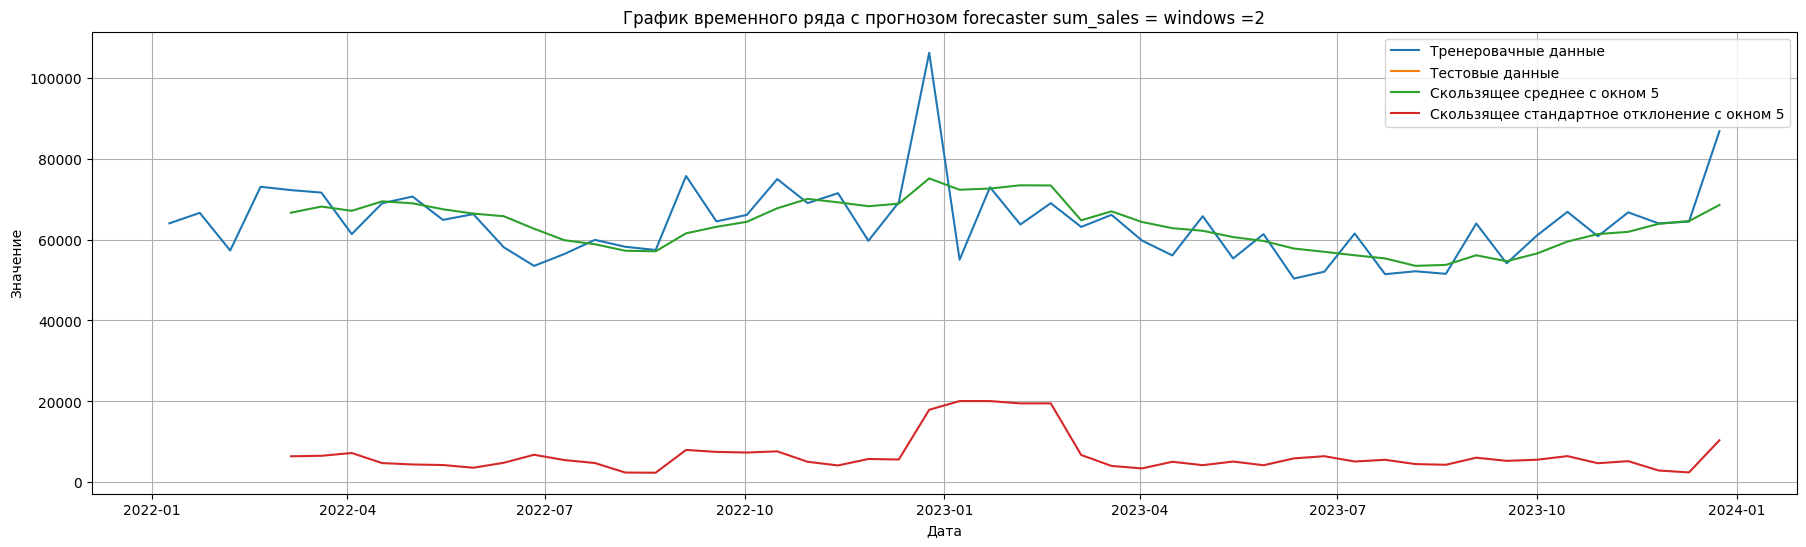

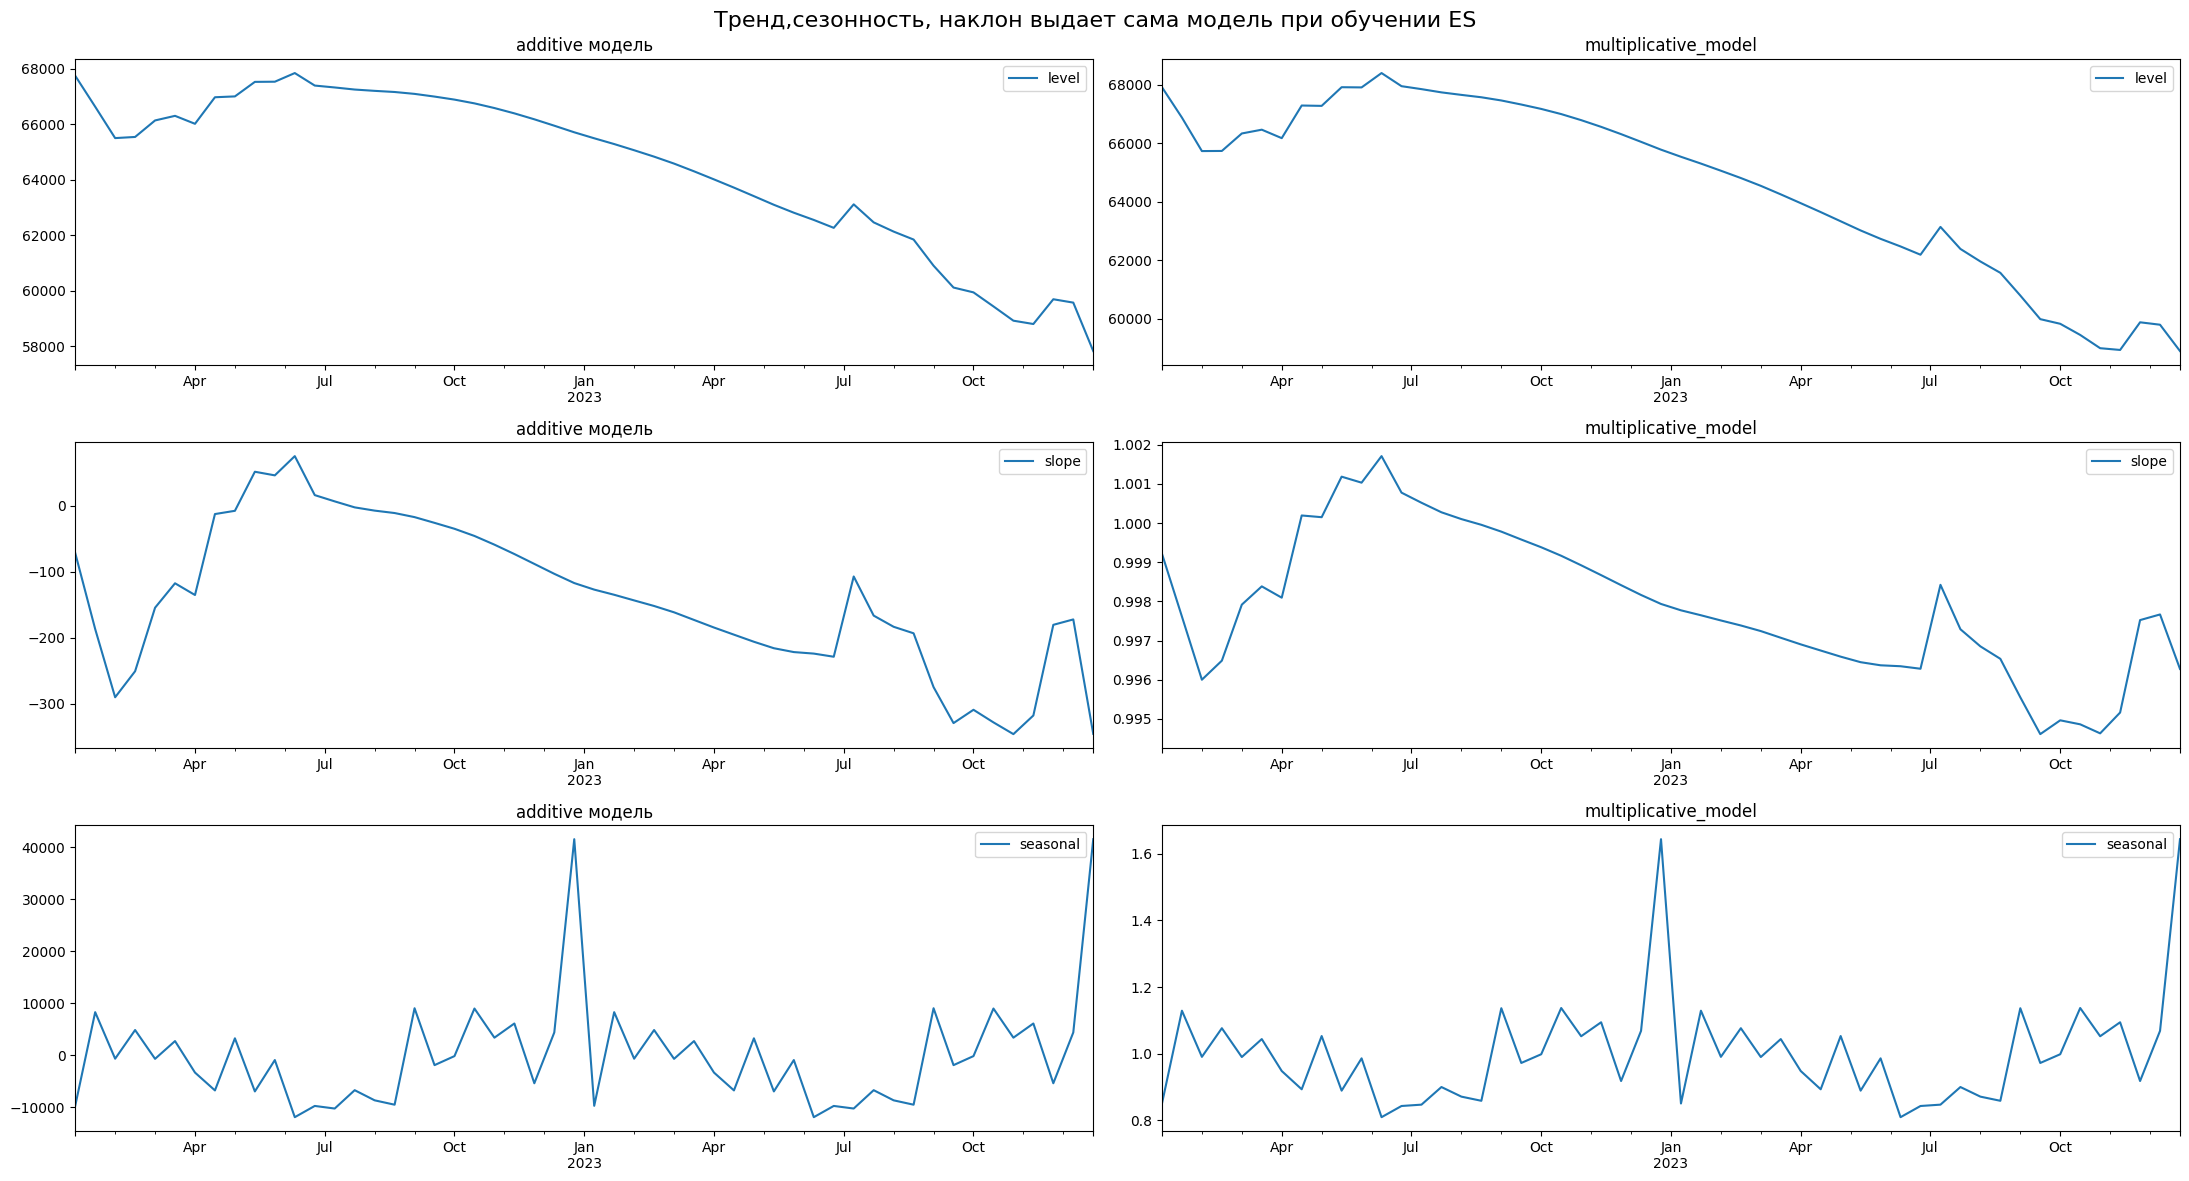

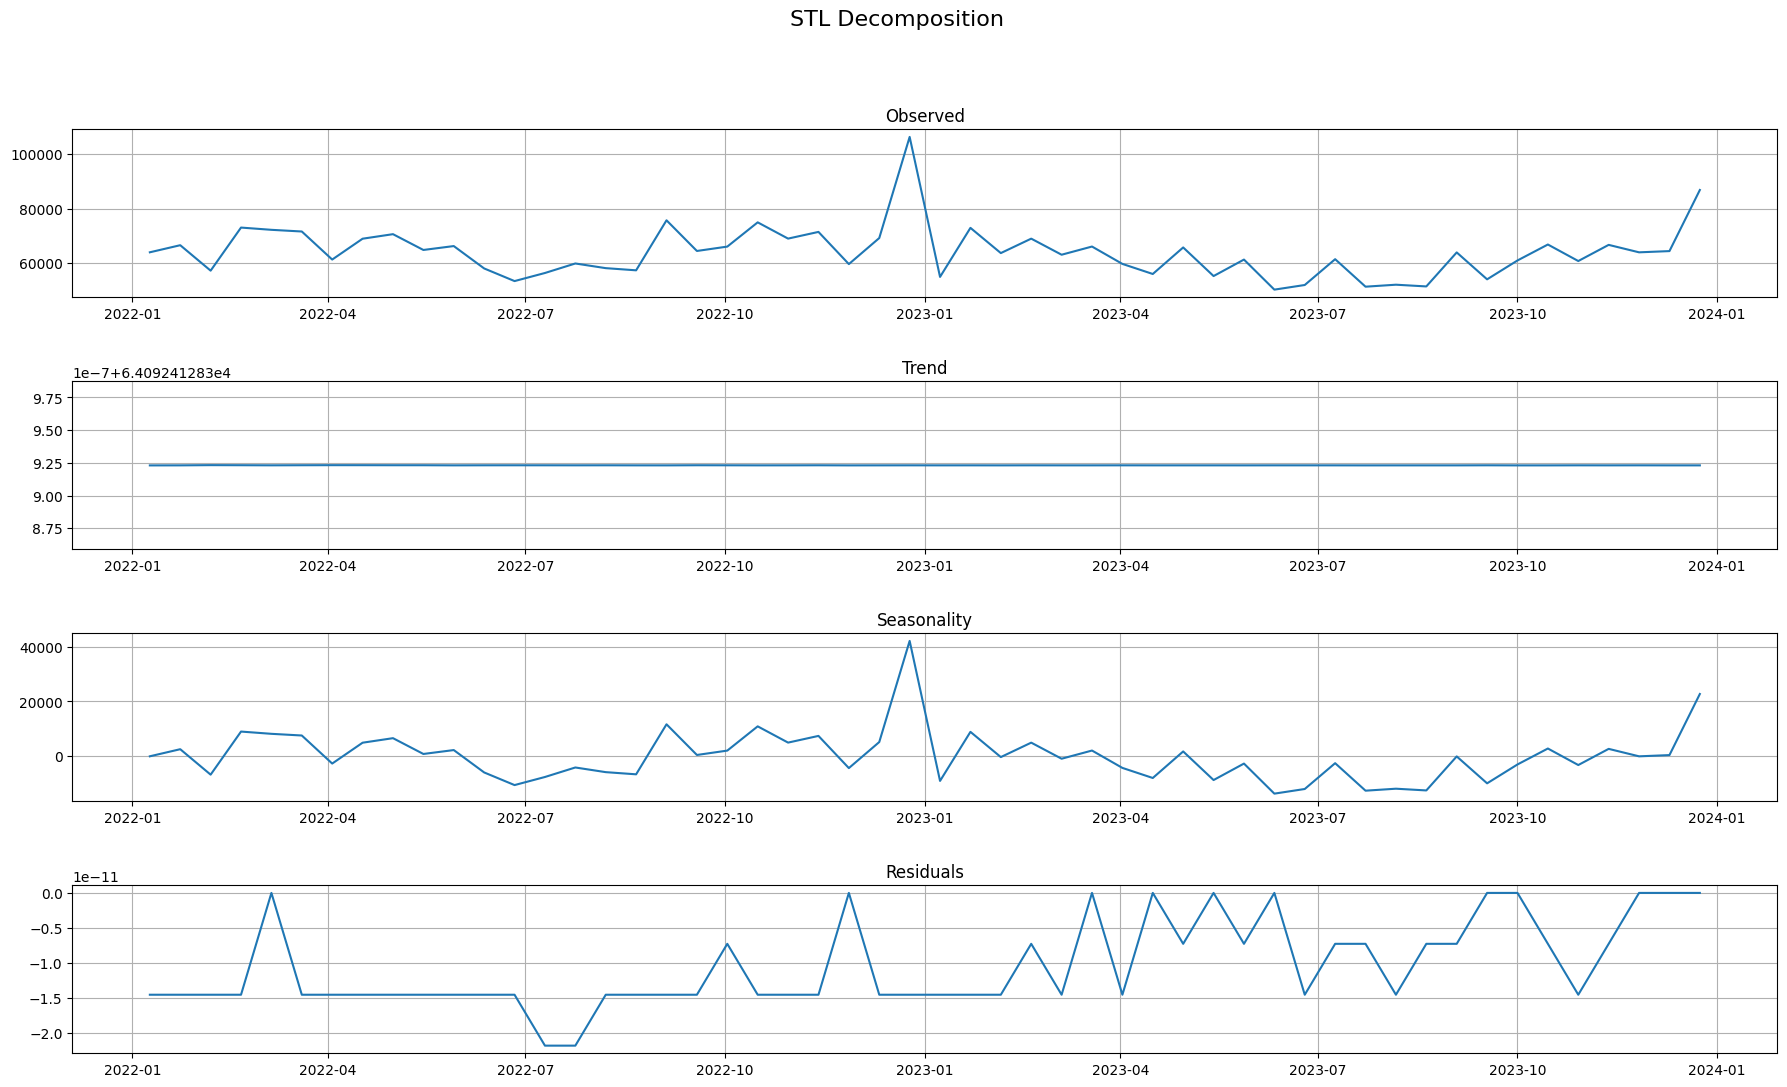

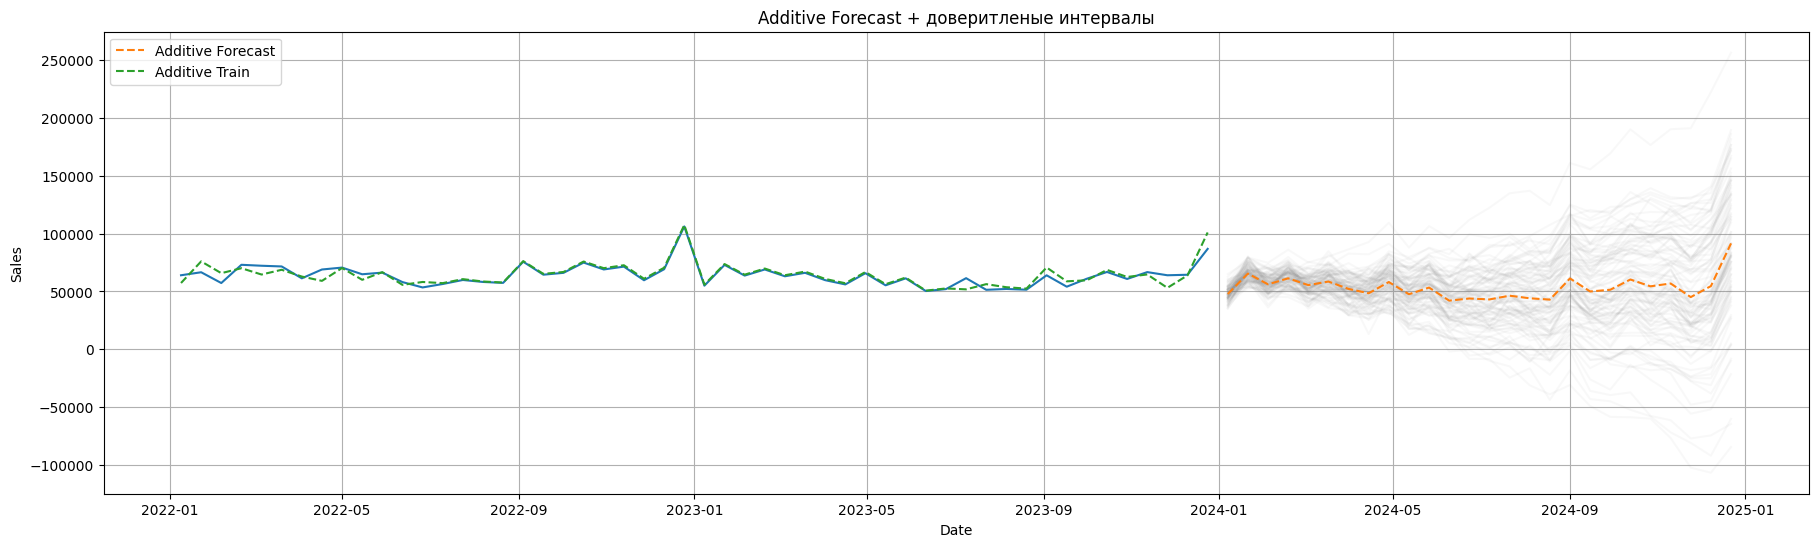

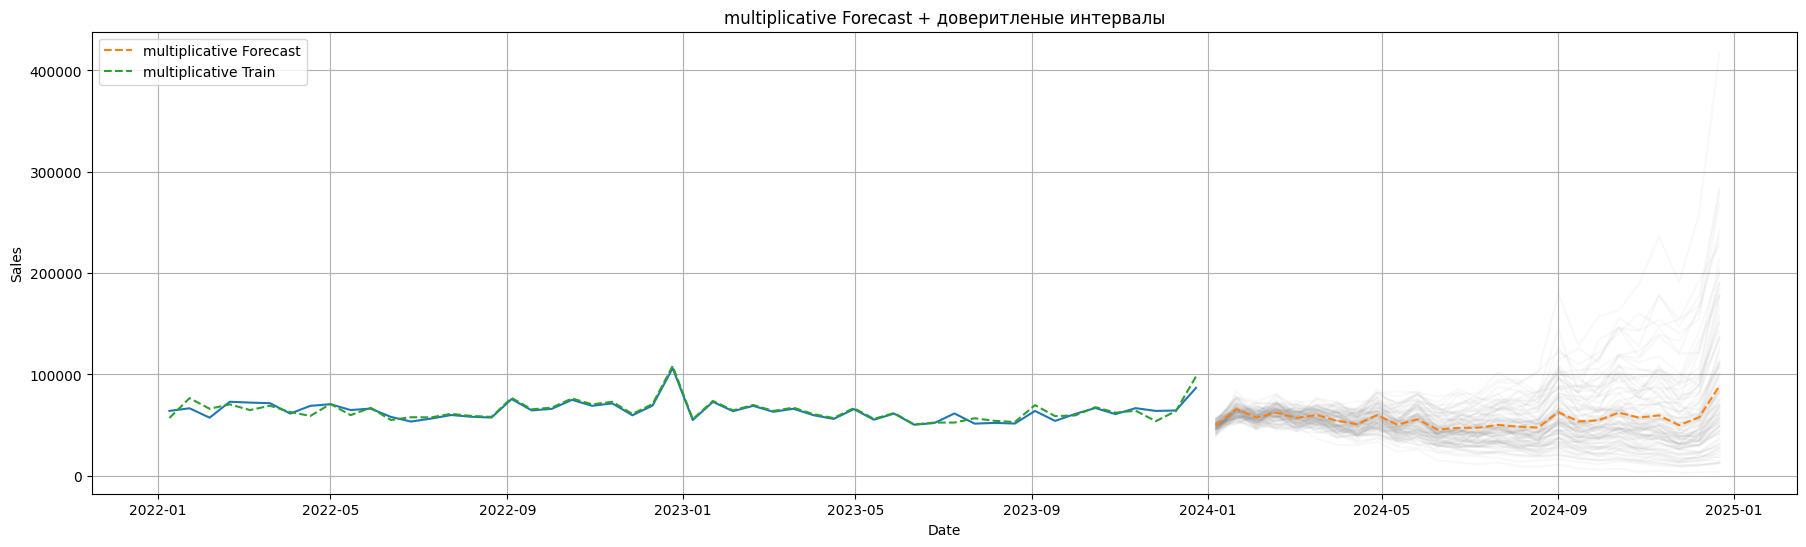

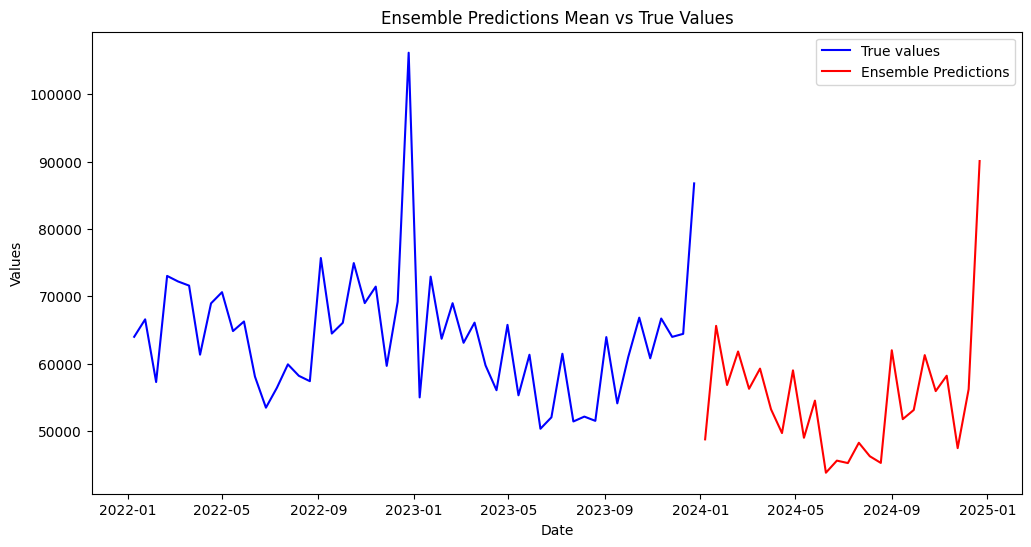

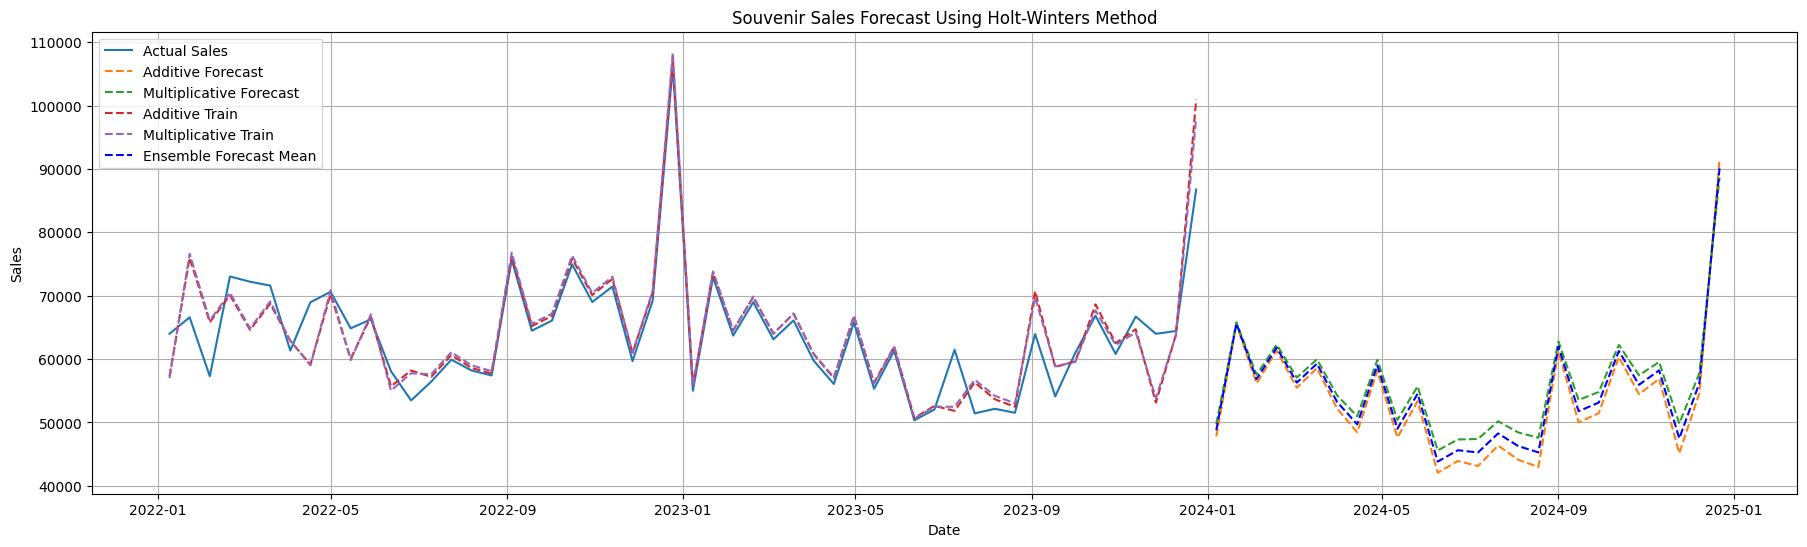

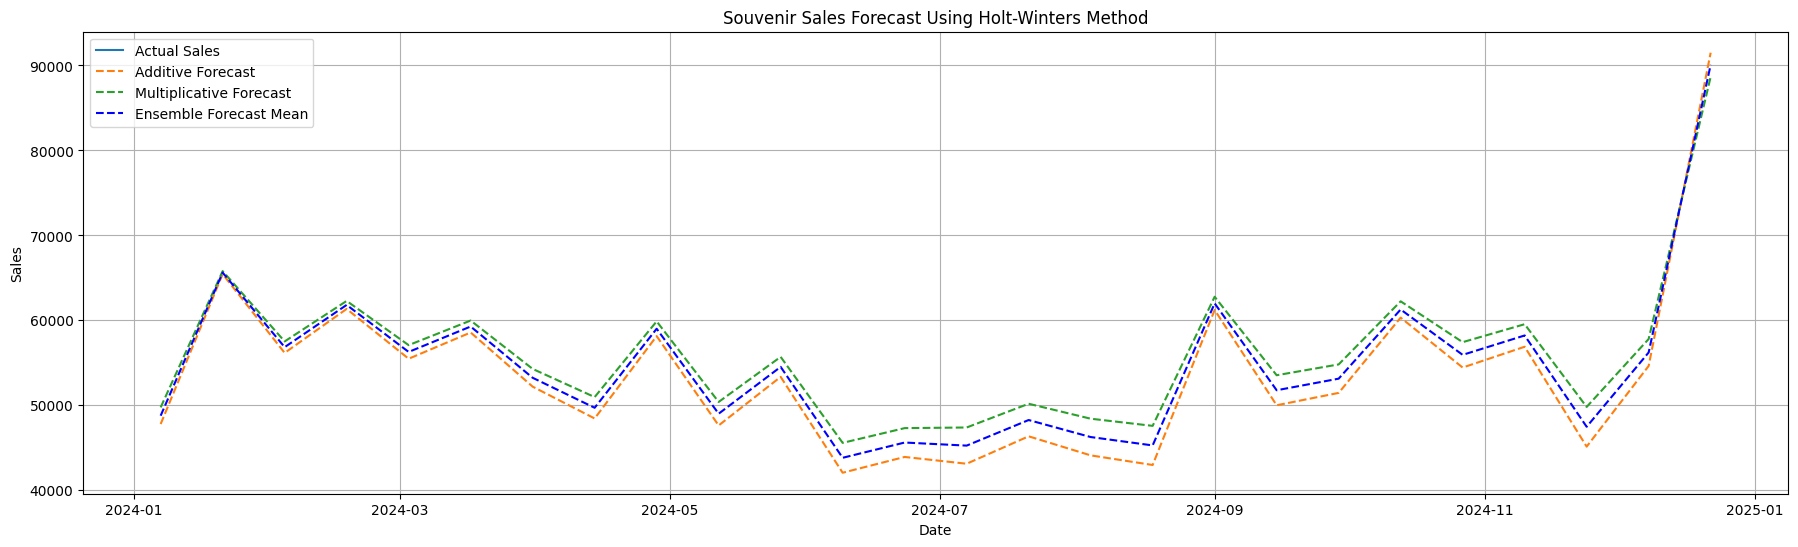

Train_additive_model_Mean Absolute Error_средняя абсолютная ошибка: 2785.209148920918
Train_additive_model_Mean Squared Error_Среднеквадратичная ошибка: 18622446.703240495
Train_additive_model_Mean Absolute Percentage Error_Средняя абсолютная процентная ошибка: 0.043122703291644776
Train_additive_model_R^2 Score_Коэффициент детерминации: 0.7893139463589812
______________________
Train_multiplicative_model_Mean Absolute Error_средняя абсолютная ошибка: 2819.1618416486385
Train_multiplicative_model_Mean Squared Error_Среднеквадратичная ошибка: 17179294.557148717
Train_multiplicative_model_Mean Absolute Percentage Error_Средняя абсолютная процентная ошибка: 0.0438313277059961
Train_multiplicative_model_R^2 Score_Коэффициент детерминации: 0.8056411258810328



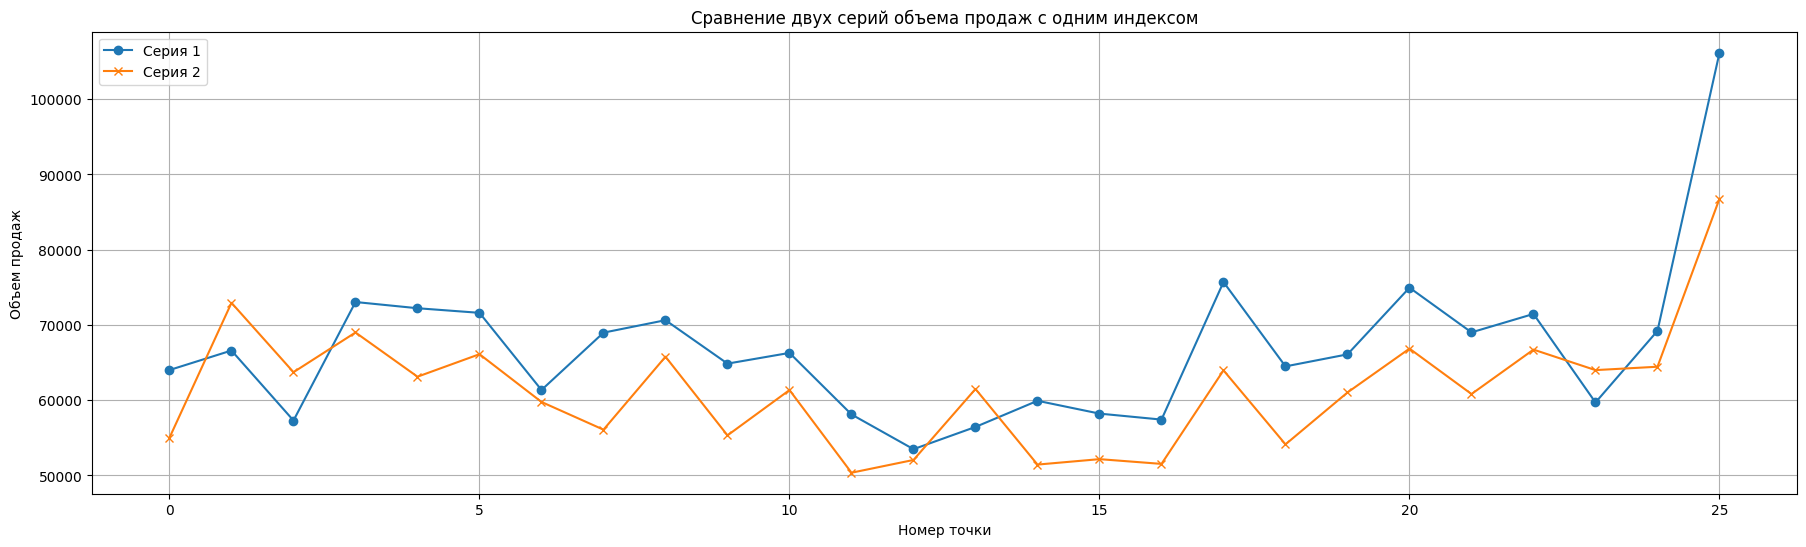

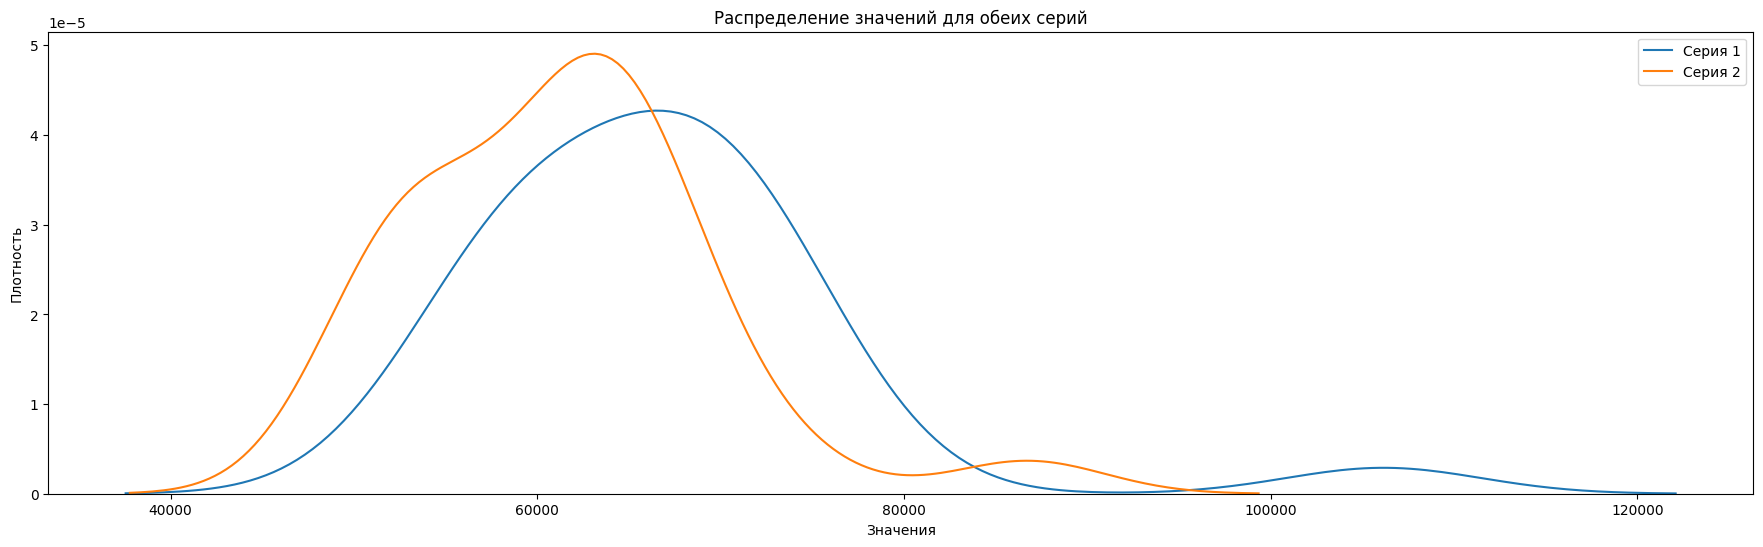

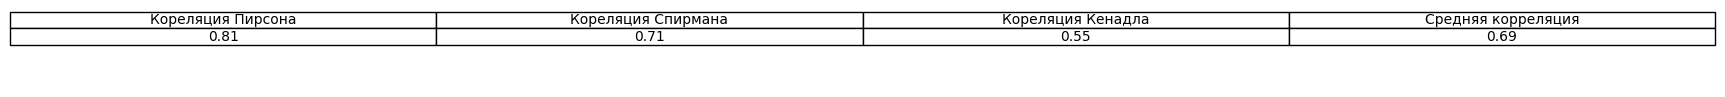

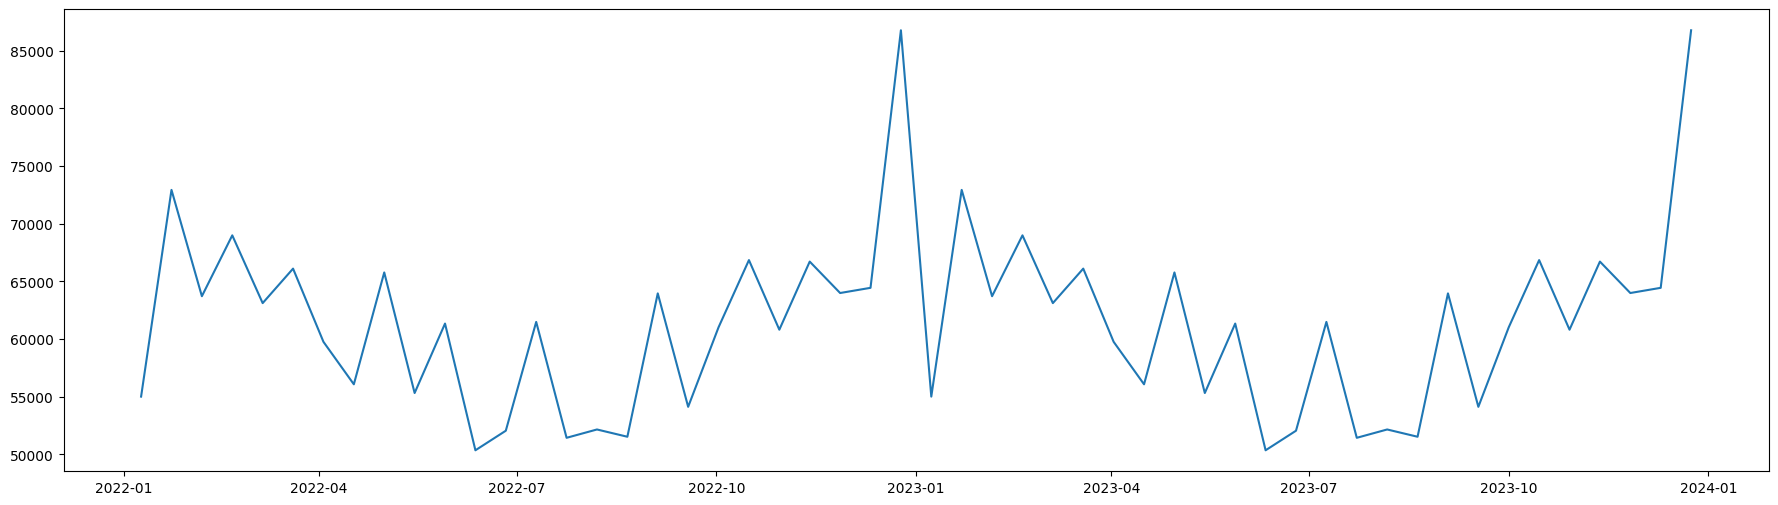

Статистика: 2.1341556018960617
P-значение: 0.03775741797365351
Различия между выборками являются статистически значимыми.
Различия между выборками являются статистически значимыми.
q1 <class 'list'>
gggod
2024-01-07    48782.042336
2024-01-21    65622.953719
2024-02-04    56849.344934
2024-02-18    61820.105309
2024-03-03    56286.474674
2024-03-17    59278.633296
2024-03-31    53246.984522
2024-04-14    49716.360794
2024-04-28    59018.089097
2024-05-12    49018.766047
2024-05-26    54530.740845
2024-06-09    43831.350532
2024-06-23    45626.371687
2024-07-07    45264.125211
2024-07-21    48274.649972
2024-08-04    46273.613719
2024-08-18    45286.756467
2024-09-01    62002.304843
2024-09-15    51778.915935
2024-09-29    53142.391902
2024-10-13    61283.460979
2024-10-27    55943.420451
2024-11-10    58224.556029
2024-11-24    47480.985013
2024-12-08    56223.847625
2024-12-22    90078.719644
Freq: 2W-SUN, Name: predict_mean, dtype: float64


In [30]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from math import sqrt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

end_train = '2023-12-24 23:59:59'
end_train_26 = '2023-12-24 23:59:59'



# Замените 'file.xlsx' на путь к вашему файлу Excel
# data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/zvezda/Server_zvezda/Dataset/test1.xlsx',
#                    )
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/zvezda/Server_zvezda/Dataset/Пленка_db_query.xlsx',
                   )

data['Time']= pd.date_range(start='2022-01', freq='W',periods=104)

data = data.set_index('Time')
data = data.asfreq('W')
data.index.name=None
data.drop(['Date_week','retailer','analytic4','group_name','region'],inplace=True, axis=1)
data = data['SALES VOL']

# Calculate the moving average with window size 3

# new_data = outline_error(data)
new_data = sum_rolling(data)

moving_avg, moving_std, win = rolling(new_data) #data


# Добавление прогноза на график
plt.figure(figsize=(22, 6))
plt.plot(new_data.index[new_data.index<=end_train], new_data[:end_train], label='Тренеровачные данные')
plt.plot(new_data.index[new_data.index>=end_train], new_data[end_train:],label='Тестовые данные')
plt.plot(moving_avg,label=f'Скользящее среднее с окном {win}')
plt.plot(moving_std,label=f'Скользящее стандартное отклонение с окном {win}')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title(f'График временного ряда с прогнозом forecaster sum_sales = windows =2')
plt.legend()
plt.grid(True)
plt.show()



predict_ensemble = model_Exponential_Smoothing(new_data) #data

corr_mean, new_time_series_split_2, test_mean = split_2(new_data)
print('q1',type(corr_mean))
if corr_mean[0] < 0.5:
    print('corr_mean',corr_mean)
    model_Exponential_Smoothing(new_time_series_split_2)
if test_mean < 0.05:
    print('gggod')




In [44]:
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Определите функцию потерь (MAE)
def mae_loss_mean(params, time_series, test_data):


    # Распаковка параметров
    smoothing_level, smoothing_trend, smoothing_seasonal = params

    # Создание модели с заданными параметрами
    model = ExponentialSmoothing(
        time_series,
        trend="add",
        seasonal='add',
        seasonal_periods=26,
        damped_trend=True

    ).fit(smoothing_level=smoothing_level,
        smoothing_trend=smoothing_trend,
        smoothing_seasonal=smoothing_seasonal)

    # Делаем прогнозы
    forecast = model.forecast(26)

    # Вычисляем MAE
    mae = np.mean(np.abs(forecast - test_data))

    return mae

[0.10161807 2.26327756 0.16413669]


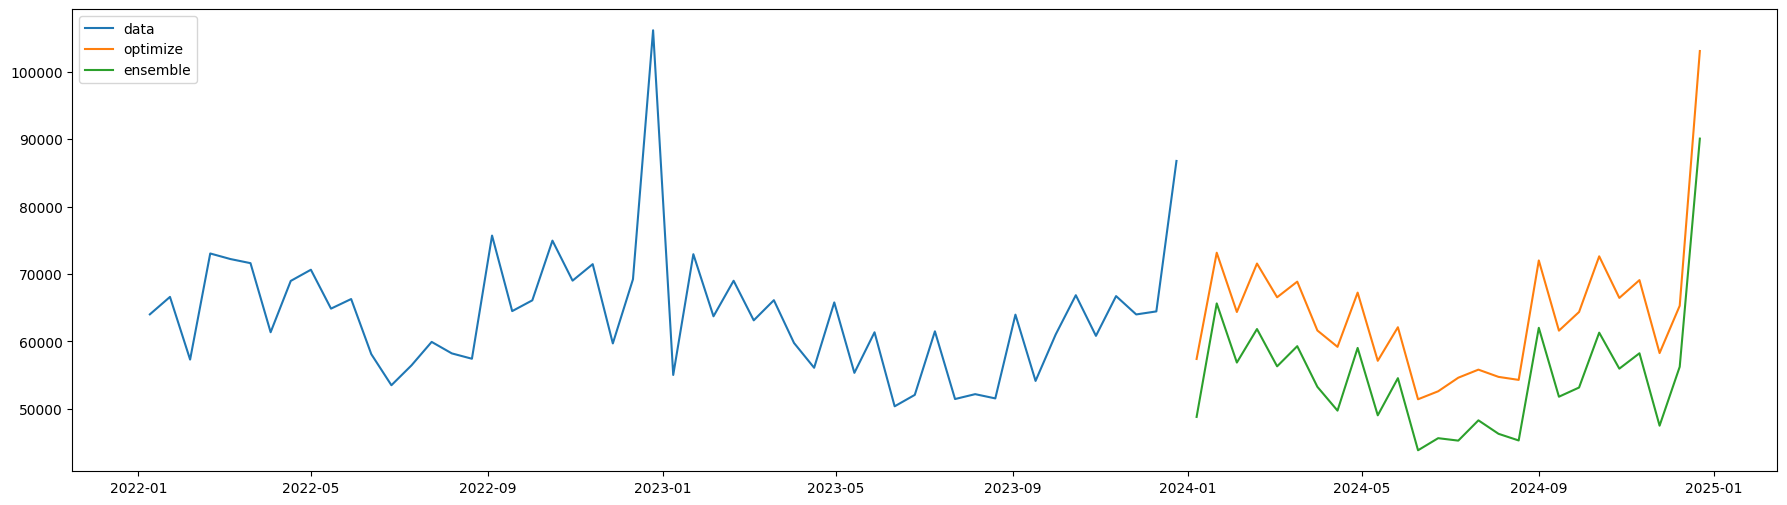

In [52]:
def test_mean_optimize(time_series,predict_ensemble):
    import numpy as np
    from scipy.optimize import minimize

    split_point = len(time_series)//2

    df = pd.DataFrame()
    df['Series_1'] = time_series[:split_point].values
    df['Series_2'] = time_series[split_point:split_point*2].values
    df['mean_Sereies_1_2_test'] = (df['Series_1']+df['Series_2'])/2
    df['predict_ensemble_train'] = predict_ensemble.values
    df.index = predict_ensemble.index




    initial_params = [0.5, 0.5, 0.5]

    # Минимизация ошибки MAE
    result = minimize(mae_loss_mean, initial_params, args=(time_series, df['mean_Sereies_1_2_test']), method='Nelder-Mead')
    # Распаковка оптимизированных параметров

    smoothing_level_opt, smoothing_trend_opt, smoothing_seasonal_opt = result.x

    additive_model_optimize = ExponentialSmoothing(
        time_series,
        trend="add",
        seasonal='add',
        seasonal_periods=26,
        damped_trend=True
    ).fit(smoothing_level=smoothing_level_opt,
          smoothing_trend=smoothing_trend_opt,
          smoothing_seasonal=smoothing_seasonal_opt)

    forecast_optimize = additive_model_optimize.forecast(26)
    plt.figure(figsize=(22, 6))
    plt.plot(time_series,label='data')
    plt.plot(forecast_optimize, label='optimize')
    plt.plot(predict_ensemble, label='ensemble')
    plt.legend()

    plt.show()



test_mean_optimize(new_data,predict_ensemble)